## Introduction

This BigQuery Graph demo operates on below presented and populated with precooked data schema.
It simulates the manufacturing production process of `final_products` including:
- suppliers providing materials used to produce final product:
  - `suppliers`
  - `material_deliveries`
  - `materials_inventory`
  - `product_materials_used`
- machines used in production process of final products:
  - `machines`
  - `product_machines_used`
- products becoming input ingredients used to produce final product
  - `product_to_product_used`



---


### Scenario
Use BigQuery Graph to investigate if there is any dependency between faulty products `final_products.customer_complaints = true` and factors like `product_machines_used.experimental_settings = true` or some suppliers.

Machine configuration data is not used for this investigation.

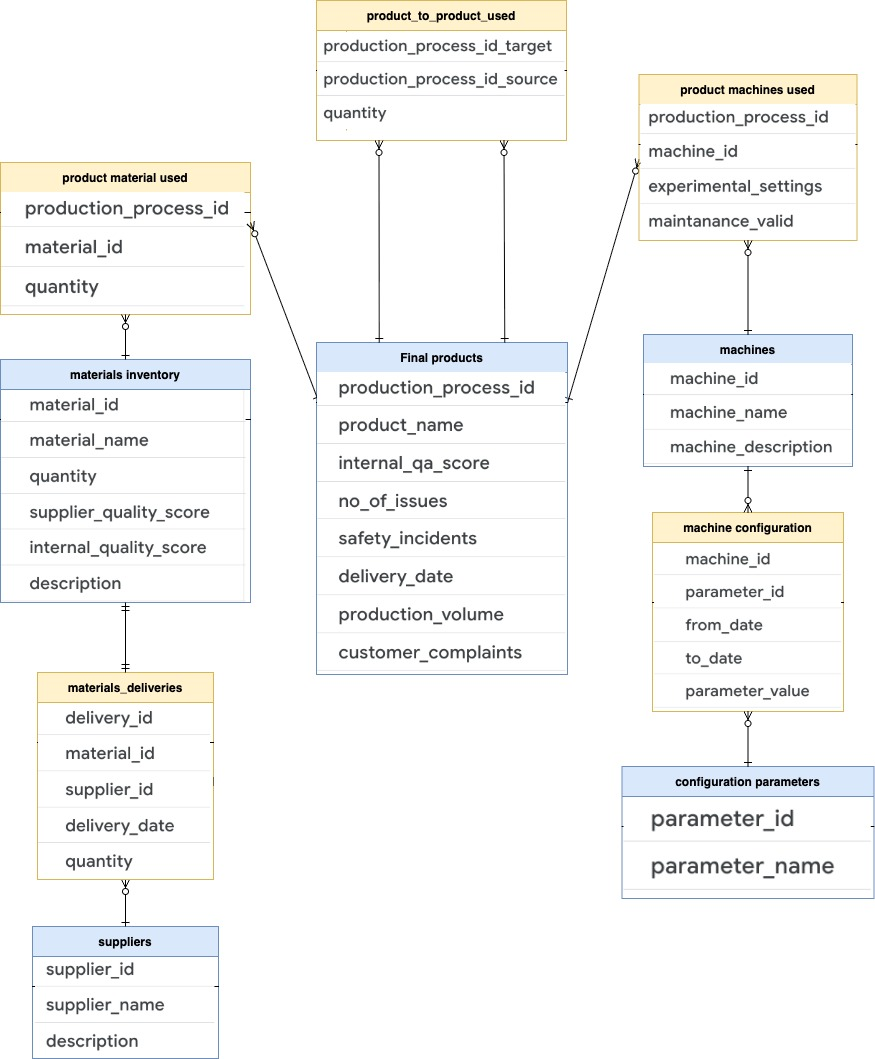

In [ ]:
!gcloud auth application-default login

In [ ]:
!pip install bigquery_magics==0.8.1
!pip install spanner-graph-notebook==1.1.5

## Basic examples - look into the data

This section is just to display and play graph layout, observe data relationships

### Just a node
No edges => nothigh to visualize

In [ ]:

%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
MATCH (p:Product {production_process_id: "83431f4f-470b-4511-a0e7-172fe2b48082"})
RETURN  TO_JSON(p) as p


### Suppliers providing materials
Suppliers providing materials to material inventory

In [ ]:
%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
MATCH (s:Supplier)-[p:Provides]->(m:Material)
RETURN TO_JSON(s) AS s, TO_JSON(p) AS p, TO_JSON(m) AS m

### Materials for particular product
Show all meterials used for particular product production

In [ ]:

%%bigquery --graph

GRAPH demo_dataset.ProductGraph02
MATCH (m:Material {material_id:"b46531c9-53c0-4605-a9ec-19a233fe2929"})-[is_used:IsIngredientInProduction]->(p:Product )
RETURN TO_JSON(m) as m, TO_JSON(is_used) as is_used, TO_JSON(p) as p


### Materials and suppliers for particular product
One step deeper: Show all **suppliers** and meterials used for particular product production

In [ ]:

%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
MATCH (s:Supplier)-[provides:Provides]->(m:Material)-[is_used:IsIngredientInProduction]->(p:Product {production_process_id: "83431f4f-470b-4511-a0e7-172fe2b48082"})
RETURN TO_JSON(s) as s, TO_JSON(provides) as provides, TO_JSON(m) as m, TO_JSON(is_used) as is_used, TO_JSON(p) as p


## Simple examples - look into the faulty products

### Materials for products with customer complaints (quite good)
#### Let's look into products with customer complaints only
Expected 38 nodes, 31 edges

In [ ]:
%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
OPTIONAL MATCH
(m:Material)-[is_used:IsIngredientInProduction]->(p:Product {customer_complaints: True})
RETURN
TO_JSON(m) as m, TO_JSON(is_used) as is_used, TO_JSON(p) as p;

### Materials for products with customer complaints (better)
Expected 39 nodes, 31 edges

Notice one extra node with product without any materials used

In [ ]:
%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
MATCH (p:Product {customer_complaints: True})
OPTIONAL MATCH (m:Material)-[is_used:IsIngredientInProduction]->(p)
RETURN
TO_JSON(m) as m, TO_JSON(is_used) as is_used, TO_JSON(p) as p;

## Regular examples

### Supplier -> Material -> Product -> Customer with complaints
#### One step deeper: add suppliers
Let's see who (which suppliers) provide materials for faulty products.

Notice the syntax used: MATCH (product) + OPTIONAL MATCH

In [ ]:
%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
MATCH (prod:Product  {customer_complaints: True})
OPTIONAL MATCH (s:Supplier)-[provides_rel:Provides]->(m:Material)-[is_used:IsIngredientInProduction]->(prod)
RETURN TO_JSON(s) as s, TO_JSON(provides_rel) as provides_rel, TO_JSON(m) as m, TO_JSON(is_used) as is_used, TO_JSON(prod) as prod

We can see two suppliers:
- SUP0090
- SUP0091

are providing materials for 8 out of 9 faulty products.

### Machines used for production

#### GQL generated with Gemini

Let's see which machines are used in production of faulty products

In [ ]:
# prompt: show graph with   machines used for all products with customer complaints

%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
MATCH (m:Machine)-[u:IsMachineUsedInProduction]->(p:Product {customer_complaints: True})
RETURN TO_JSON(m) as m, TO_JSON(p) as p, TO_JSON(u) as u
;


Nothing valuable here, a lot of machines are used in production of faulty products

### Machines with experimental settings

Let's check machines with experimental settings, which are used in production of faulty products

In [ ]:
# prompt: for all products with customer complaints show graph with materials and  machines used for production

%%bigquery --graph
GRAPH demo_dataset.ProductGraph02
# MATCH (m:Machine )-[u:IsMachineUsedInProduction{experimental_settings: True}]->(p:Product {customer_complaints: True})
MATCH (p:Product {customer_complaints: True})
OPTIONAL MATCH (m:Machine )-[u:IsMachineUsedInProduction{experimental_settings: True}]->(p)
RETURN TO_JSON(m) as m, TO_JSON(p) as p, TO_JSON(u) as u
;



Nothing usefull above. Among 9 faulty products, there are 5 that were produced using machines with experimental setting and 4 products, where machines with experimental settings were not involved.

## Complex examples

### All candidates together (almost)
Expected 44 nodes, 66 edges

Let's look into machines, suppliers and material on one graph.

We will see 2 faulty products (nodes) without either experimental machine or suspicious supplier connected.

In [ ]:
%%bigquery --graph

GRAPH demo_dataset.ProductGraph02
MATCH (p:Product {customer_complaints: True})
OPTIONAL MATCH (machine:Machine)-[machine_rel:IsMachineUsedInProduction {experimental_settings: True}]->(p)
OPTIONAL MATCH (supplier:Supplier)-[provides:Provides]->(material:Material)-[material_rel:IsIngredientInProduction]->(p)
RETURN
  TO_JSON(p) as product,
  TO_JSON(machine) as machine,
  TO_JSON(machine_rel) as machine_rel,
  TO_JSON(material) as material,
  TO_JSON(material_rel) as material_rel,
  TO_JSON(supplier) as supplier,
  TO_JSON(provides) as provides


**What is wrong with the pink nodes?**

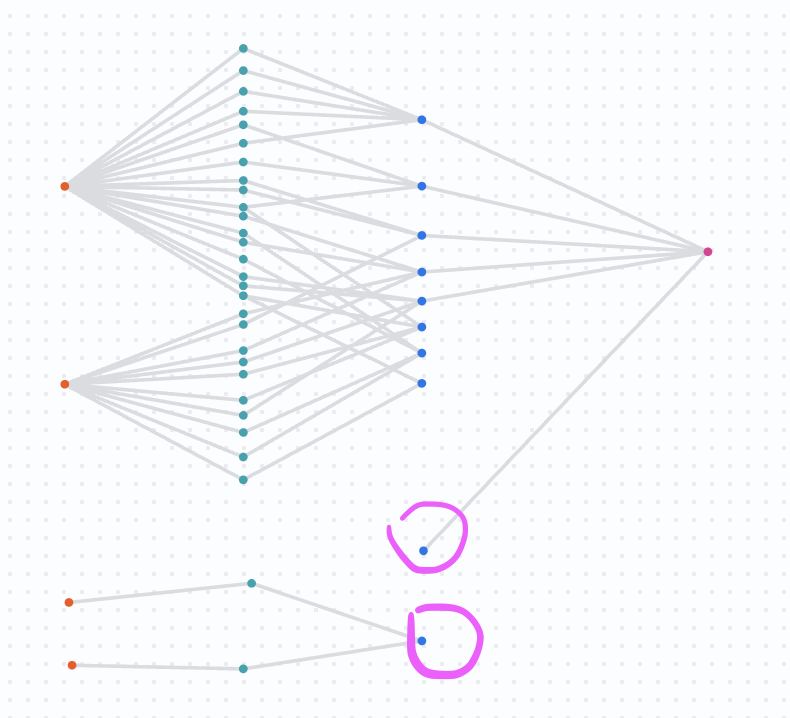

### All candidates together (all)
#### This time let's combine ALL relations to the products.

Adding product to product relation, as some products are used as ingredients for other products.

Notice the depth `]->{1,10}(p)` of the recursive relation between nodes

If You change 10 to 3, You will see less products as ingredients, but the chain will not reach to the first faulty product.

In [ ]:
%%bigquery --graph

GRAPH demo_dataset.ProductGraph02
MATCH (p:Product {customer_complaints: True})
OPTIONAL MATCH (machine:Machine)-[machine_rel:IsMachineUsedInProduction {experimental_settings: True}]->(p)
OPTIONAL MATCH (supplier:Supplier)-[provides:Provides]->(material:Material)-[material_rel:IsIngredientInProduction]->(p)
OPTIONAL MATCH (source_product:Product)-[is_used:IsUsedInProduction]->{1,10}(p)
RETURN
  TO_JSON(p) as product,
  TO_JSON(machine) as machine,
  TO_JSON(machine_rel) as machine_rel,
  TO_JSON(material) as material,
  TO_JSON(material_rel) as material_rel,
  TO_JSON(supplier) as supplier,
  TO_JSON(provides) as provides,
  TO_JSON(source_product) as source_product,
  TO_JSON(is_used) as is_used
;



### Final discovery
Now we can see, why two products can be faulty (have customer complaints).
Even though no material from bad suppliers (SUP0090, SUP0091) were used to produce them.

They other faulty products (that have connection to bad suppliers) were used to produce them.


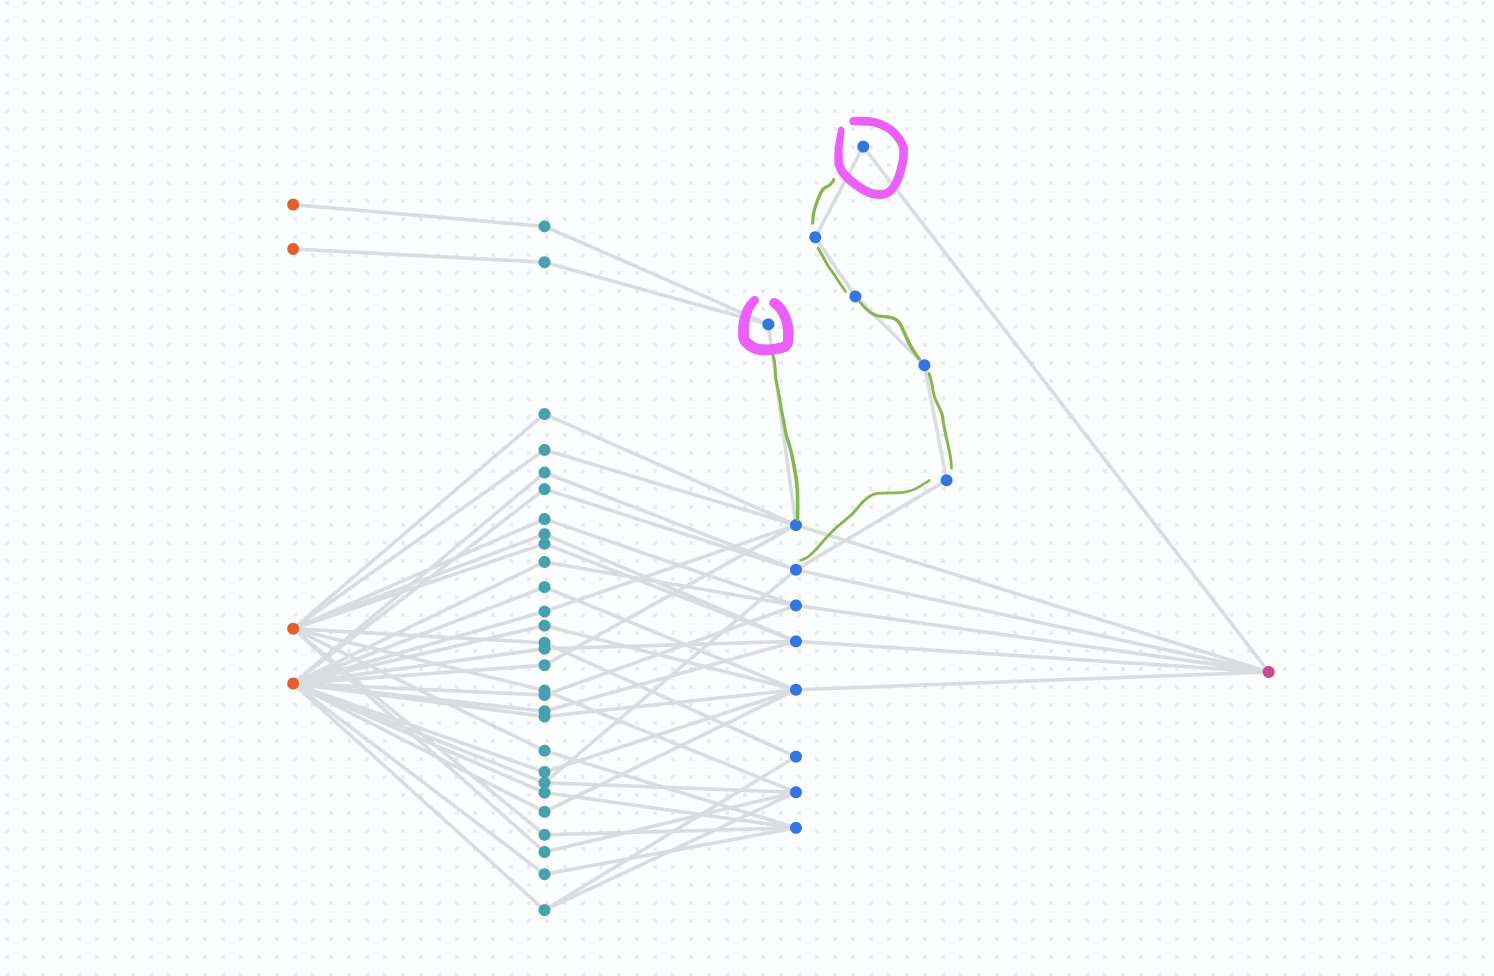